In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import mean_absolute_error


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

## Project: Forecasting Consumer Goods Prices
------

For this project, we’ll use the historical monthly average retail price of food in Canada, from 1995 until February 2022. The dataset, titled “Monthly average retail prices for food and other selected products,” is available for download from Statistics Canada ([StatCan](www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000201)).

The price of a basket of goods is an important macroeconomic indicator. This is what composes the consumer price index (CPI), which is used to determine if there is an inflationary or deflationary period. This in turn allows analysts to assess the effectiveness of the economic policy, and it can of course impact programs of government assistance, such as social security. If the price of goods is expected to rise, the amount reserved for social security should technically increase.

The original dataset contains the monthly average retail price of 52 goods, from 1 kilogram of round steak to a dozen eggs, 60 grams of deodorant, and gasoline, to name a few. The price is reported in Canadian dollars for every month starting in 1995 to Februrary 2022.

In [293]:
df = pd.read_csv('avg_retailprice_food_CAN.csv', header = 0)

df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-01,Canada,2016A000011124,"Sirloin steak, 1 kilogram",Dollars,81,units,0,v735176,1.2,11.25,NaN,NaN,NaN,2
2,1995-01,Canada,2016A000011124,"Prime rib roast, 1 kilogram",Dollars,81,units,0,v735187,1.3,12.08,NaN,NaN,NaN,2
3,1995-01,Canada,2016A000011124,"Blade roast, 1 kilogram",Dollars,81,units,0,v735198,1.4,7.23,NaN,NaN,NaN,2
4,1995-01,Canada,2016A000011124,"Stewing beef, 1 kilogram",Dollars,81,units,0,v735209,1.5,7.12,NaN,NaN,NaN,2


In [294]:
print(f"A total of {len(df.Products.unique())} distinct products")

A total of 62 distinct products


In [295]:
for prod in df.Products.unique():
    print(prod)

Round steak, 1 kilogram
Sirloin steak, 1 kilogram
Prime rib roast, 1 kilogram
Blade roast, 1 kilogram
Stewing beef, 1 kilogram
Ground beef, 1 kilogram
Pork chops, 1 kilogram
Butt roast, 1 kilogram
Chicken, 1 kilogram
Bacon, 500 grams
Wieners, 450 grams
Canned salmon, 213 grams
Homogenized milk, 1 litre
Partly skimmed milk, 1 litre
Butter, 454 grams
Processed cheese slices, 250 grams
Evaporated milk, 385 millilitres
Eggs, 1 dozen
Bread, 675 grams
Soda crackers, 450 grams
Macaroni, 500 grams
Flour, 2.5 kilograms
Corn flakes, 675 grams
Apples, 1 kilogram
Bananas, 1 kilogram
Grapefruits, 1 kilogram
Oranges, 1 kilogram
Apple juice, 1.36 litres
Orange juice, 1 litre
Cabbage, 1 kilogram
Carrots, 1 kilogram
Celery, 1 kilogram
Mushrooms, 1 kilogram
Onions, 1 kilogram
Potatoes, 4.54 kilograms
French fried potatoes, frozen, 1 kilogram
Baked beans, canned, 398 millilitres
Tomatoes, canned, 796 millilitres
Tomato juice, 1.36 litres
Ketchup, 1 litre
Sugar, white, 2 kilograms
Coffee, roasted, 300 gra

In [296]:
product = ['Grapefruits, 1 kilogram', 'Soft drinks, cola type, 2 litres']

df_grapef = df[df.Products == product[0]]
df_pop = df[df.Products == product[1]]

In [297]:
cols_to_drop = ['GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID', 
                'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

df_grapef = df_grapef.drop(cols_to_drop, axis = 1)
df_pop = df_pop.drop(cols_to_drop, axis = 1)

df_grapef.head()

,REF_DATE,VALUE
25,1995-01,1.31
84,1995-02,1.31
143,1995-03,1.38
202,1995-04,1.44
261,1995-05,1.55


In [298]:
df_pop.head()

,REF_DATE,VALUE
49,1995-01,1.39
108,1995-02,1.41
167,1995-03,1.32
226,1995-04,1.29
285,1995-05,1.30


In [299]:
df_grapef.isna().sum()

REF_DATE    0
VALUE       0
dtype: int64

In [300]:
df_pop.shape, df_grapef.shape

((290, 2), (280, 2))

In [301]:
from pandas.tseries.offsets import MonthEnd

df_pop['REF_DATE'] = pd.to_datetime(df_pop['REF_DATE']) + MonthEnd(1)
df_grapef['REF_DATE'] = pd.to_datetime(df_grapef['REF_DATE']) + MonthEnd(1)

df_pop.columns = ['month', 'avg_price']
df_grapef.columns = ['month', 'avg_price']

df_pop.head()

,month,avg_price
49,1995-01-31,1.39
108,1995-02-28,1.41
167,1995-03-31,1.32
226,1995-04-30,1.29
285,1995-05-31,1.30


In [302]:
df_pop = df_pop.set_index('month')
df_grapef = df_grapef.set_index('month')

In [303]:
def check_missing_dates(df: pd.DataFrame):

         
    complete_range = pd.date_range(start=df.index[0], end=df.index[-1], freq='M')
        
    missing_dates = complete_range.difference(df.index)
    
    if len(missing_dates) == 0:

        print(f'There are no missing date within the range time-series is defined')

    else:

        print(f'Missing dates are:\n')

        for md in missing_dates:

            print(md)

check_missing_dates(df_pop)
check_missing_dates(df_grapef)

There are no missing date within the range time-series is defined
There are no missing date within the range time-series is defined


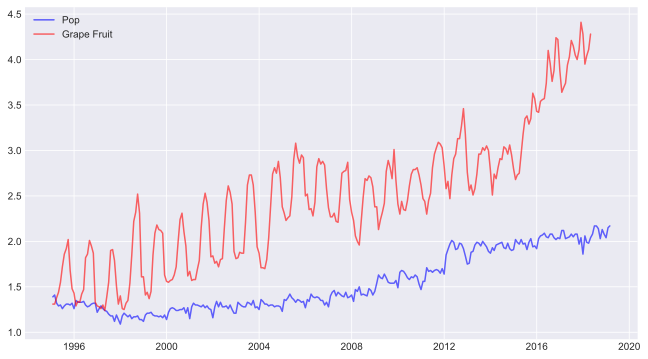

In [304]:
fig, axes = plt.subplots(figsize = (11,6))

axes.plot(df_pop, color = 'blue', alpha = 0.6, label = 'Pop')
axes.plot(df_grapef, color = 'red', alpha = 0.6, label = 'Grape Fruit')

axes.grid()
axes.legend()

Both series have some seasonal patterns but this is more apparent for the grape fruit price. Both time series have a clear trend which is somewhat monotonic with some exceptions.

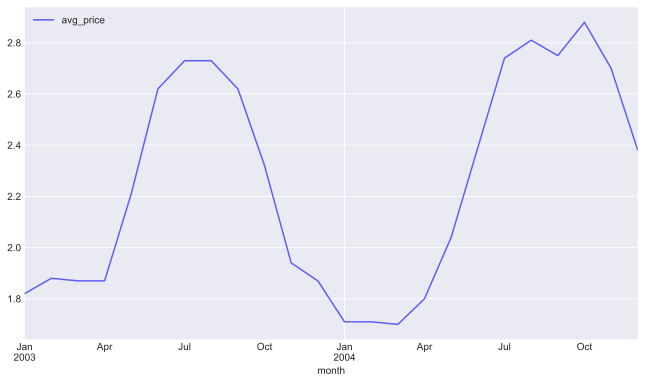

In [305]:
fig, axes = plt.subplots(figsize = (11,6))

df_grapef['2003':'2004'].plot(ax = axes, color = 'blue', alpha = 0.6)

axes.grid()

### 1. Problem Description
-------
The seasonality component in the grape fruit prices are more clear, so for the purpose of showing the capabilities of Prophet we will focus on average grape fruite price. Our task will be to predict its price for the next 24 months!


### 2. Data Exploration
-------
Lets have a look at the ETS decomposition of the avg grape fruite price and its distribution. 

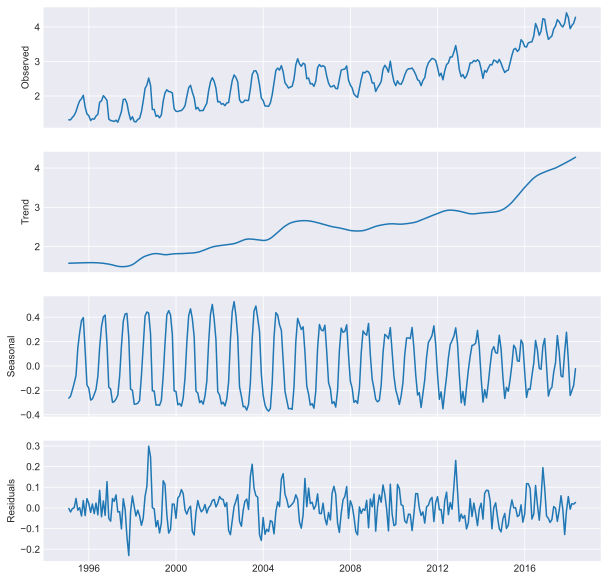

In [306]:
# STL decomposition to see trend and seasonality more clearly

decomp = STL(df_grapef['avg_price'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()

There are clear non-monotonic trend and chaning variance in the seasonal component. 

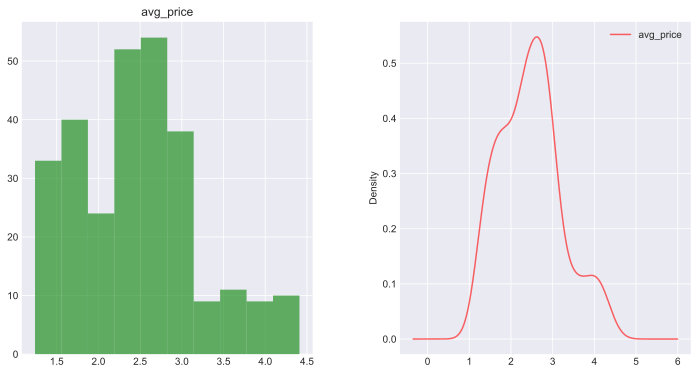

In [307]:
fig, axes = plt.subplots(1,2, figsize = (12,6))

df_grapef.hist(ax = axes[0], color= 'green', alpha = 0.6)
df_grapef.plot(kind = 'kde', ax = axes[1], color= 'red', alpha = 0.6)

axes[1].grid()

Double Gaussian like distribution. We may benefit from tranforming the series especially for a SARIMA type model. 

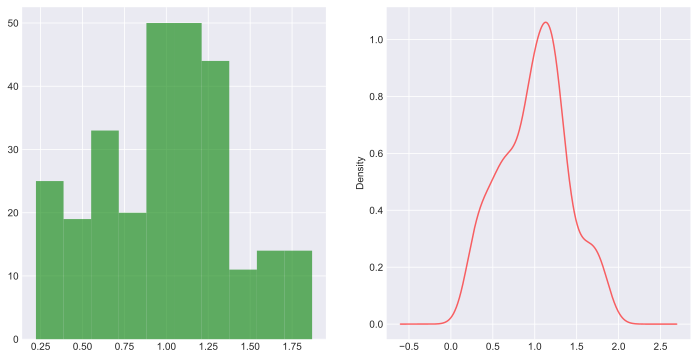

In [308]:
fitted_vals, lamb = boxcox(df_grapef['avg_price'])

df_grapef['avg_price_t'] = fitted_vals

fig, axes = plt.subplots(1,2, figsize = (12,6))

df_grapef['avg_price_t'].hist(ax = axes[0], color= 'green', alpha = 0.6)
df_grapef['avg_price_t'].plot(kind = 'kde', ax = axes[1], color= 'red', alpha = 0.6)

axes[1].grid()

The transformation trimmed the bi-modal distribution a bit. But it is not good enough. 

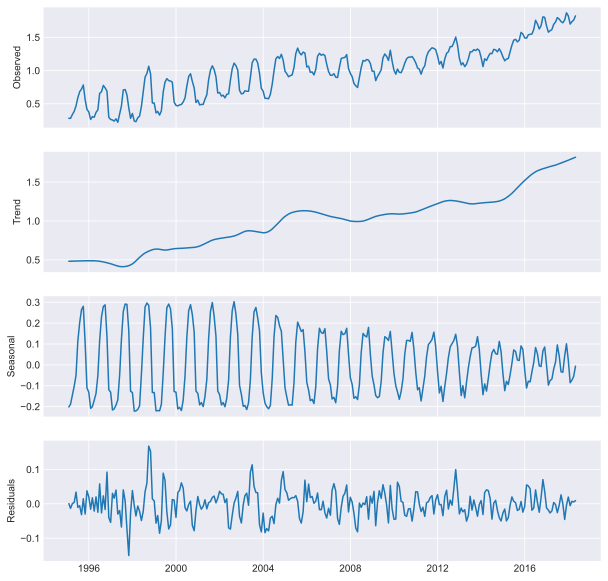

In [309]:
# STL decomposition of the transformed data to see trend and seasonality more clearly

decomp = STL(df_grapef['avg_price_t'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()

Apart from scaling data, see that seasonality for the first few years has now a constant variance but towards the end of the data set its variance is still decreasing. 

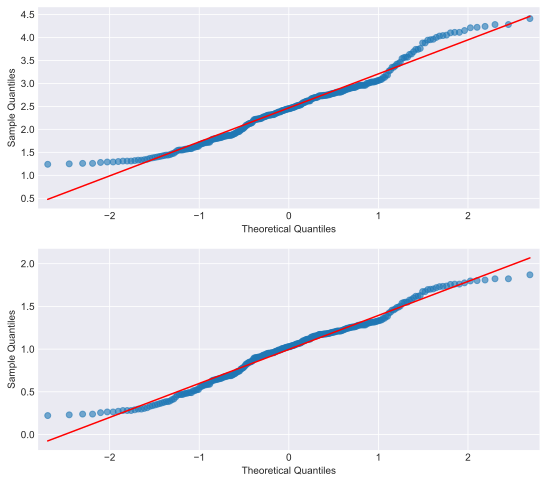

In [310]:
# qq plot of the original data vs box-cox transformed data

fig, axes = plt.subplots(2,1,figsize = (9,8))

qqplot(df_grapef['avg_price'], ax = axes[0], alpha = 0.6, line='r');
qqplot(df_grapef['avg_price_t'], ax = axes[1], alpha = 0.6, line='r');


axes[0].grid()
axes[1].grid()

The "normality" of the data seems like imporved slightly with respect to raw data.  

In [356]:
# remove the index and rename the columns as 'ds' and 'y' for both data sets 

dfp = pd.DataFrame()
dfpt = pd.DataFrame()

dfp['ds'] = df_grapef.index
dfpt['ds'] = df_grapef.index

dfp['y'] = df_grapef['avg_price'].values
dfpt['y'] = df_grapef['avg_price_t'].values

In [357]:
# train test split 
Ntest = 24

train, test = dfp[:-Ntest], dfp[-Ntest:]

ttrain, ttest = dfpt[:-Ntest], dfpt[-Ntest:]

### 3. Apply Prophet and get the hyperparameters through Cross Validation (Walk forward validation)
-------

Prophet comes with many parameters that can be fine-tuned by more advanced users in order to produce better forecasts. Four parameters are usually tuned: `changepoint_prior_scale`, `seasonality_prior_scale`, `holidays_prior_scale`, and `seasonality_mode`:

- `changepoint_prior_scale`: The `changepoint_prior_scale` parameter is said to be the most impactful parameter in Prophet. It determines the flexibility of the trend, and particularly how much the trend changes at the trend change points. If the parameter is too small, the trend will underfit, and the variance observed in the data will be treated as noise. If it is set too high, the trend will overfit to noisy fluctuations. Using the range `[0.001, 0.01, 0.1, 0.5]` is enough to have a well-fitted model.

- `seasonality_prior_scale`: The `seasonality_prior_scale` parameter sets the flexibility of the seasonality. A large value allows the seasonal component to fit smaller fluctuations, while a small value will result in a smoother seasonal component. Using the range `[0.01, 0.1, 1.0, 10.0]` generally works well to find a good model.

- `holidays_prior_scale`: The holidays_prior_scale parameter sets the flexibility of the holiday effects and works just like `seasonality_prior_scale`. It can be tuned using the same range, `[0.01, 0.1, 1.0, 10.0]`.

- `seasonality_mode`: The seasonality_mode parameter can be either `additive` or `multiplicative`. By default, it is additive, but it can be set to multiplicative if you see that the seasonal fluctuation gets larger over time. This can be observed by plotting the time series, but when in doubt, you can include it in the hyper-parameter tuning process.

We’ll now move on to the next step, where we’ll combine hyperparameter tuning and cross-validation to find the optimal parameter combination for our model. 

Holidays will not likely effect the price of grape fruit, so we will not grid search over holiday_prior scale. 

In [313]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'], 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
              'seasonality_prior_scale': [0.01, 0.1, 1., 10.]} # 'holidays_prior_scale': [0.01, 0.1, 1., 10.] can be added

In [314]:
from itertools import product

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

Now, because we are working with monthly data, we must define our own cutoff dates. Recall that the cutoff dates define the training and testing periods during cross-validation. 

Here we’ll set the initial training period to be the first 5 years of data. Therefore, our first cutoff date will be `2000-01-31`. The last cutoff date can be set as the 24 months prior to the last row of the training set `2014-04-30`, and we’ll separate each cutoff date by 24 months, so that we have a model that forecasts a full three years.

In [287]:
train.tail(25)

,ds,y
231,2014-04-30,2.81
232,2014-05-31,2.91
233,2014-06-30,2.90
234,2014-07-31,3.04
235,2014-08-31,3.02
236,2014-09-30,2.96
237,2014-10-31,3.06
238,2014-11-30,2.95
239,2014-12-31,2.80
240,2015-01-31,2.68


In [288]:
cutoffs = pd.date_range(start='2000-01-31', end='2014-04-30', freq='24M')

# evaluation metric to decide best parameter combination 

mse_vals = []

for param in params:

    m = Prophet(**param)

    m.fit(train)

    df_cv = cross_validation(model = m, horizon = '365 days', cutoffs = cutoffs, parallel='processes') # parallelize across cores
    df_p = performance_metrics(df_cv, rolling_window = 1) # rolling_window = 1 to average the metrics over the walk forward steps 

    mse_vals.append(df_p['mse'].values[0])

hptune_res = pd.DataFrame(params)

hptune_res['mse'] = mse_vals


19:44:43 - cmdstanpy - INFO - Chain [1] start processing
19:44:43 - cmdstanpy - INFO - Chain [1] done processing
19:44:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:44:43 - cmdstanpy - INFO - Chain [1] start processing
19:44:44 - cmdstanpy - INFO - Chain [1] done processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] start processing
19:44:47 - cmdstanpy - INFO - Chain [1] done processing
19:44:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:44:4

In [289]:
# best model has additive seasonality, changepoint_prior_scale = 0.01, seasonality_prior_scale = 10.0

hptune_res.sort_values('mse')

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,mse
7,additive,0.010,10.00,0.042472
6,additive,0.010,1.00,0.042731
5,additive,0.010,0.10,0.042959
11,additive,0.100,10.00,0.045527
10,additive,0.100,1.00,0.046144
3,additive,0.001,10.00,0.046270
2,additive,0.001,1.00,0.046383
9,additive,0.100,0.10,0.046828
1,additive,0.001,0.10,0.047412
4,additive,0.010,0.01,0.049867


In [290]:
best_params = params[hptune_res.sort_values('mse').index[0]]

print(f"Best performing model has the following hyper-parameters:\n{best_params}")

Best performing model has the following hyper-parameters:
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


In [315]:
# lets repeat the process with box-cox transformed data

cutoffs = pd.date_range(start='2000-01-31', end='2014-04-30', freq='24M')

tmse_vals = []

for param in params:

    m = Prophet(**param)

    m.fit(ttrain)

    df_cv = cross_validation(model = m, horizon = '365 days', cutoffs = cutoffs, parallel='processes') # parallelize across cores
    df_p = performance_metrics(df_cv, rolling_window = 1) # rolling_window = 1 to average the metrics over the walk forward steps 

    tmse_vals.append(df_p['mse'].values[0])

thptune_res = pd.DataFrame(params)

thptune_res['mse'] = tmse_vals

19:53:13 - cmdstanpy - INFO - Chain [1] start processing
19:53:13 - cmdstanpy - INFO - Chain [1] done processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] start processing
19:53:17 - cmdstanpy - INFO - Chain [1] done processing
19:53:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:53:17 - cmdstanpy - INFO - Chain [1] done processing
19:53:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
19:53:17 - cmdstanpy - INFO - Chain [1] done processing
19:53:17 - 

In [316]:
# best model has additive seasonality, changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.1
# this is not surprising as by box-cox transform we rendered the variance in the seasonality constant 
# this also caused a reduction in the seasonality_prior_scale, however the model needed to increase the changepoint_prior_scale to add more flexibility

thptune_res.sort_values('mse')

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,mse
9,additive,0.100,0.10,0.015719
13,additive,0.500,0.10,0.015902
5,additive,0.010,0.10,0.015973
10,additive,0.100,1.00,0.016153
6,additive,0.010,1.00,0.016259
7,additive,0.010,10.00,0.016305
11,additive,0.100,10.00,0.016317
14,additive,0.500,1.00,0.016341
15,additive,0.500,10.00,0.016682
1,additive,0.001,0.10,0.018458


In [317]:
tbest_params = params[thptune_res.sort_values('mse').index[0]]

print(f"Best performing model on the transformed data has the following hyper-parameters:\n{tbest_params}")

Best performing model on the transformed data has the following hyper-parameters:
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


Since we have the best model for both approaches we undertake, we can fit them into the entire training set and evaluate them on the test set.

In [344]:
# un-transformed model 

m = Prophet(**best_params)
m.fit(train);

future_df = m.make_future_dataframe(periods = 24, freq = 'M') # generates a df with all in sample and out of sample values 

forecast = m.predict(future_df)

20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing


In [345]:
# add the predictions yhat and upper/lower limits to the test set 

test.loc[test.index, ['yhat', 'yhat_lower', 'yhat_upper']] = forecast.loc[test.index, ['yhat', 'yhat_lower', 'yhat_upper']].values

test

,ds,y,yhat,yhat_lower,yhat_upper
256,2016-05-31,3.74,3.075190,2.833010,3.320616
257,2016-06-30,4.10,3.335813,3.082923,3.587841
258,2016-07-31,3.96,3.518456,3.274566,3.763717
259,2016-08-31,3.76,3.544289,3.280948,3.784484
260,2016-09-30,3.88,3.520077,3.277007,3.759079
261,2016-10-31,4.24,3.498090,3.247707,3.732241
262,2016-11-30,4.22,3.227578,2.975073,3.471725
263,2016-12-31,3.88,3.079798,2.834054,3.322575
264,2017-01-31,3.64,2.979961,2.730605,3.222748
265,2017-02-28,3.69,2.994142,2.738609,3.251021


In [384]:
# Set a baseline as the last month of the training set as the predictions for the next 24 months

test.loc[test.index, 'naive'] = train['y'].iloc[-1]
test.head()

,ds,y,yhat_sarima,yhat_sarima_l,yhat_sarima_u,naive
ds,,,,,,
2016-05-31,2016-05-31,3.74,3.666545,3.369359,3.981604,3.57
2016-06-30,2016-06-30,4.10,3.760384,3.367072,4.184770,3.57
2016-07-31,2016-07-31,3.96,3.798396,3.348596,4.288859,3.57
2016-08-31,2016-08-31,3.76,3.719883,3.242386,4.244534,3.57
2016-09-30,2016-09-30,3.88,3.689150,3.191182,4.239098,3.57


In [347]:
# we evaluate the performance of the Prophet using MAE with respect to the baseline 

p_mae = mean_absolute_error(test['y'], test['yhat'])
b_mae = mean_absolute_error(test['y'], test['naive'])

print(f"Test MAE Prophet vs Naive Seasonal Forecast: {p_mae:.3f} vs {b_mae:.3f}")

Test MAE Prophet vs Naive Seasonal Forecast: 0.744 vs 0.447


Our model does not seem to beat a naive baseline which simply uses the last known value as forecast. 

In [358]:
# Repeat the same process with the model suitable for the transformed data 

mt = Prophet(**tbest_params)


mt.fit(ttrain)

future_dft = mt.make_future_dataframe(periods = 24, freq = 'M') # generates a df with all in sample and out of sample values 

tforecast = mt.predict(future_dft)

tforecast.head()

20:24:45 - cmdstanpy - INFO - Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1995-01-31,0.410112,0.124908,0.383275,0.410112,0.410112,-0.156151,-0.156151,-0.156151,-0.156151,-0.156151,-0.156151,0.0,0.0,0.0,0.253960
1,1995-02-28,0.413178,0.112558,0.381229,0.413178,0.413178,-0.160601,-0.160601,-0.160601,-0.160601,-0.160601,-0.160601,0.0,0.0,0.0,0.252577
2,1995-03-31,0.416573,0.111800,0.371620,0.416573,0.416573,-0.172622,-0.172622,-0.172622,-0.172622,-0.172622,-0.172622,0.0,0.0,0.0,0.243951
3,1995-04-30,0.419859,0.153248,0.404208,0.419859,0.419859,-0.145761,-0.145761,-0.145761,-0.145761,-0.145761,-0.145761,0.0,0.0,0.0,0.274097
4,1995-05-31,0.423254,0.240540,0.488210,0.423254,0.423254,-0.057870,-0.057870,-0.057870,-0.057870,-0.057870,-0.057870,0.0,0.0,0.0,0.365384


In [359]:
# add the predictions yhat and upper/lower limits to the test set 

ttest.loc[ttest.index, ['yhat', 'yhat_lower', 'yhat_upper']] = tforecast.loc[ttest.index, ['yhat', 'yhat_lower', 'yhat_upper']].values

ttest.head()

,ds,y,yhat,yhat_lower,yhat_upper
256,2016-05-31,1.618474,1.358537,1.221344,1.489103
257,2016-06-30,1.756933,1.513361,1.390843,1.646699
258,2016-07-31,1.704140,1.617225,1.492769,1.747518
259,2016-08-31,1.626405,1.634344,1.507356,1.767553
260,2016-09-30,1.673383,1.614347,1.494343,1.732373


In [360]:
def inverse_boxcox(y, lambda_val):
    if lambda_val == 0:
        return np.exp(y)
    else:
        return (y * lambda_val + 1) ** (1 / lambda_val)

cols_to_xform = ttest.columns[1:]

for col in cols_to_xform:

    ttest[col] = inverse_boxcox(ttest[col], lamb)

/var/folders/q0/lz7h2q596yx70_f664l6gv8h0000gn/T/ipykernel_79857/2019026560.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest[col] = inverse_boxcox(ttest[col], lamb)


In [361]:
# Set a baseline as the last month of the training set as the predictions for the next 24 months

ttest.loc[test.index, 'naive'] = train['y'].iloc[-1]
ttest.tail()

/var/folders/q0/lz7h2q596yx70_f664l6gv8h0000gn/T/ipykernel_79857/538148336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest.loc[test.index, 'naive'] = train['y'].iloc[-1]


,ds,y,yhat,yhat_lower,yhat_upper,naive
275,2017-12-31,4.28,3.258954,2.930024,3.538860,3.57
276,2018-01-31,3.95,3.125312,2.835875,3.426034,3.57
277,2018-02-28,4.04,3.132948,2.857794,3.415545,3.57
278,2018-03-31,4.11,3.116182,2.859372,3.413825,3.57
279,2018-04-30,4.28,3.189695,2.908678,3.497942,3.57


In [362]:
# we evaluate the performance of the Prophet using MAE with respect to the baseline 

tp_mae = mean_absolute_error(ttest['y'], ttest['yhat'])
tb_mae = mean_absolute_error(ttest['y'], ttest['naive'])

print(f"Test MAE Prophet (on transformed data) vs Naive Seasonal Forecast: {tp_mae:.3f} vs {tb_mae:.3f}")

Test MAE Prophet (on transformed data) vs Naive Seasonal Forecast: 0.616 vs 0.447


Performance of the Prophet on the transformed set is a bit better but not good enough to beat naive forecast.

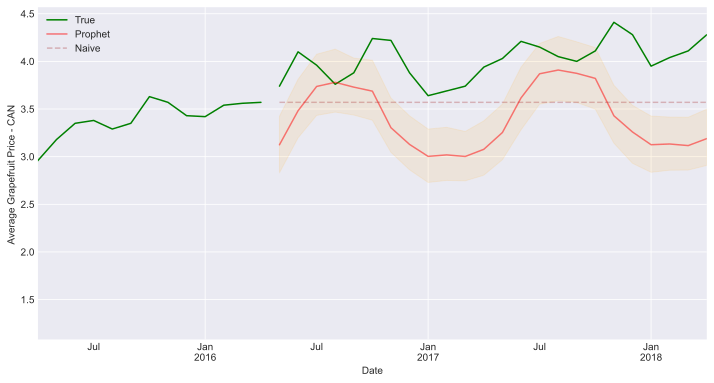

In [381]:
# Visualize the forecasts

train.index = train['ds']
ttest.index= test['ds']

fig, axes = plt.subplots(figsize = (12,6))

train['y'].plot(ax = axes, color = 'green', label = '')
ttest['y'].plot(ax = axes, color = 'green', label = 'True')
ttest['yhat'].plot(ax = axes, color = 'red', alpha = 0.5, label = 'Prophet')

ttest['naive'].plot(ax = axes, color = 'brown', ls = '--', alpha = 0.3, label = 'Naive')


axes.fill_between(x = ttest.index, y1 = ttest['yhat_lower'], y2 = ttest['yhat_upper'], color = 'orange', alpha = 0.1)


axes.set_xlim(train.index[-13],'2018-04-30')
axes.set_xlabel('Date')
axes.set_ylabel("Average Grapefruit Price - CAN ")
axes.legend()

axes.grid()


Text(0, 0.5, 'Average GF price [scaled]')

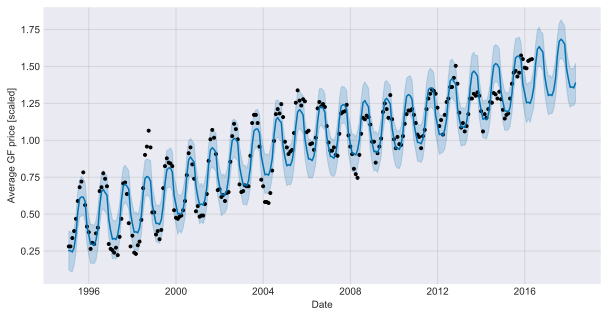

In [367]:
# Plotting in sample predictions with forecasts

fig, axes = plt.subplots(figsize = (10,5))

mt.plot(tforecast, ax = axes);

axes.set_xlabel('Date')
axes.set_ylabel('Average GF price [scaled]')

### Can we do better with SARIMA?
-----

Let's have a look if we can improve on Prophet with a SARIMA type model. 

In [368]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

We first want to determine $d$ and $D$, namely overall trend and seasonal differencing we need to implement to render the data stationary. Recall that SARIMA models work best with stationary data. Of course we can automatically determine all the model parameters $p,d,q,P,D,Q$ using `auto_arima()` method from the pmd arima library which automatically choses the best model accounding to `AIC` criterion.  

#### Augmented Dicky-Fuller, ACF and PACF
------

In [369]:
# Helper function to decide if the series is stationary or not!

def adf(x): # Note that the null hypothesis is that the TS is non-stationary

    test, p_val, *_ = adfuller(x.dropna())

    print(f"ADF test statistic: {test:.5f}")
    print(f"ADF p-value: {p_val:.5f}")

    if p_val < 0.05:
        print('Time-series is stationary!')
    else:
        print('Time-series is not stationary!')

In [370]:
# we work with boxcox transformed data 

adf(dfpt['y'])

ADF test statistic: 0.21624
ADF p-value: 0.97316
Time-series is not stationary!


In [371]:
# Check first differencing with previous vals, first differencing in the boxcox transormed data has made the series stationary!

diff_y = dfpt['y'].diff(1)

adf(diff_y)

ADF test statistic: -4.63584
ADF p-value: 0.00011
Time-series is stationary!


In [372]:
# Check first differencing + seasonal differincing 

diff_y_season = dfpt['y'].diff(1).diff(12)

adf(diff_y_season)

ADF test statistic: -7.39053
ADF p-value: 0.00000
Time-series is stationary!


We see that first differencing will already rendered the series stationary. However seasonal differencing made it even more stationary. Therefore we choose to work with a $d = 1$, $D = 1$

#### SARIMA model Selection
------
Now we have determined possible choices of $d$ and $D$, we can move on to the optimizing $p,q$ and $P,Q$. For this purpose we will use a helper function that will make a grid search of possible $p,q,P,Q$ values and sort the associated SARIMA models according to their `AIC`

In [403]:
p_vals = range(0,4,1)
q_vals = range(0,4,1)
P_vals = range(0,4,1)
Q_vals = range(0,4,1)

order_list = list(product(p_vals,q_vals,P_vals,Q_vals)) # all possible tuples of (p,q,P,Q) within the specified range 

In [438]:
def auto_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = list()

    for order in tqdm(order_list):

        try:

            model= SARIMAX(endog, exog, order = (order[0], d, order[1]), seasonal_order=(order[2],D,order[3],s), simple_differencing=False)
            model_fit = model.fit(disp = False)

        except:
            continue

        aic = model_fit.aic
        results.append([order, aic])

    res_df = pd.DataFrame(results)
    res_df.columns = ['(p,q,P,Q)', 'AIC']

    # Sort in ascending order of AIC

    res_df = res_df.sort_values(by = 'AIC', ascending=True).reset_index(drop = True)

    return res_df

In [439]:
# to suppress convergence warnings 

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# check the best Model with d = 1, D = 1 (sd = 1), and s = 12 
sd = 1
d = 1
s = 12

auto_SARIMAX(ttrain['y'], None, order_list, d, sd, 12) # we use the transformed training set: ttrain

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 1, 0, 1)",-636.638465
1,"(1, 1, 1, 1)",-635.962971
2,"(1, 1, 0, 2)",-635.951336
3,"(2, 1, 0, 1)",-635.554898
4,"(1, 2, 0, 1)",-635.542774
...,...,...
251,"(0, 2, 0, 0)",-541.309479
252,"(0, 1, 0, 0)",-539.004771
253,"(2, 0, 0, 0)",-538.627016
254,"(1, 0, 0, 0)",-536.235033


The best model on the transformed data is $\textrm{SARIMA}(1,1,1)(0,1,1)_{12}$. 

Lets work out the best model's diagnostics, focusing on the residuals.

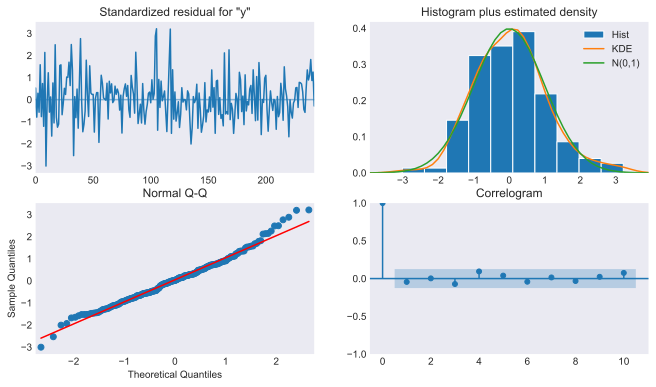

In [456]:
sarima_model = SARIMAX(ttrain['y'], order = (1,1,1), seasonal_order=(0,1,1,12), simple_differencing=False)

sarima_fit = sarima_model.fit(disp = False)

sarima_fit.plot_diagnostics(figsize = (11,6));

The residuals look very close to a white noise. It is almost Gaussian, QQ plot looks good, and no correlation between lagged residuals. Lets check this statement quantitatively with and ljung-box test

In [457]:
resids = sarima_fit.resid

df_ljungbox = acorr_ljungbox(resids, lags=np.arange(1,10,1))

df_ljungbox

,lb_stat,lb_pvalue
1,0.043312,0.835138
2,1.562071,0.457932
3,1.742935,0.627431
4,3.270460,0.513626
5,3.278677,0.657108
6,3.704979,0.716528
7,3.926123,0.788246
8,4.420550,0.817328
9,5.184099,0.817974


All lagged residuals have p-values larger than 0.05 therefore we can not reject the null hypothesis: Residuals are white noise!

In [458]:
# get predictions using the start and end index of the test set

sarima_test_tpreds = sarima_fit.get_prediction(256,279).predicted_mean

# lets also get the confidence interval
conf_int_testdf = sarima_fit.get_prediction(256,279).conf_int(alpha = 0.05)

# inverse box-cox 
sarima_test_preds = inverse_boxcox(sarima_test_tpreds, lamb)
sarima_conf_int = inverse_boxcox(conf_int_testdf, lamb)

# add them to the test df where we collect all results and actual values

test['yhat_sarima'] = sarima_test_preds.values

test[['yhat_sarima_l','yhat_sarima_u']] = sarima_conf_int.values

In [459]:
# MAE of best SARIMA model 

mae_sarima = mean_absolute_error(test['y'], test['yhat_sarima'])

print(f"Test MAE of SARIMA: {mae_sarima:.3f}")

Test MAE of SARIMA: 0.452


We indeed obtain better results with SARIMA which is almost as good as the naive forecast. However, it still can not beat the latter with a good margin. In this sense predictive power of the model should be questioned.

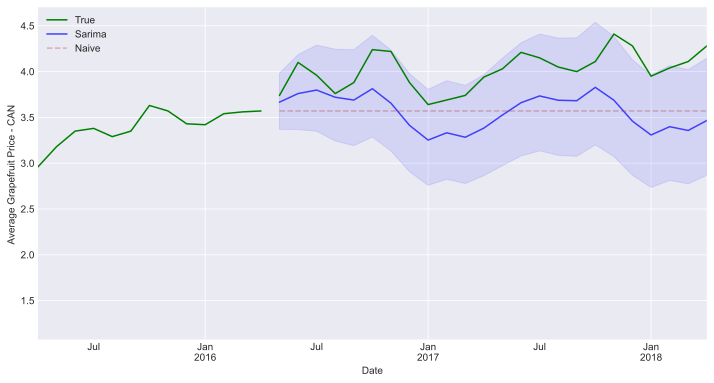

In [445]:
# Visualize the forecasts

train.index = train['ds']
test.index= test['ds']

fig, axes = plt.subplots(figsize = (12,6))

train['y'].plot(ax = axes, color = 'green', label = '')
test['y'].plot(ax = axes, color = 'green', label = 'True')
test['yhat_sarima'].plot(ax = axes, color = 'blue', alpha = 0.7, label = 'Sarima')

test['naive'].plot(ax = axes, color = 'brown', ls = '--', alpha = 0.3, label = 'Naive')


axes.fill_between(x = test.index, y1 = test['yhat_sarima_l'], y2 = test['yhat_sarima_u'], color = 'blue', alpha = 0.1)



axes.set_xlim(train.index[-13],'2018-04-30')
axes.set_xlabel('Date')
axes.set_ylabel("Average Grapefruit Price - CAN ")
axes.legend()

axes.grid()

SARIMA seems to capture quite well monthly changes however the overall level of the predicstions are off. 

At this stage should we give up? In fact, there is more in our glossary to improve this model. There is one more argument that can be feed into the SARIMA model which is `trend` to set the parameter controlling the deterministic trend polynomial. This is in similar spirit to trend component Prophet has. In our approach with SARIMA so far, we did not specify this component which by default does not include a trend component. `trend = ` argument in SARIMA method can be specified as a string where `c` indicates a constant (i.e. a degree zero component of the trend polynomial), `t` indicates a linear trend with time, and `ct` is both. It can also be specified as an iterable defining the non-zero polynomial exponents to include, in increasing order. For example, `[1,1,0,1]` denotes

$$ a + b\, t + c\, t^3$$

Modifying `auto_SARIMAX()` function we defined earlier, I tried all available `trend` options to obtain by best hyper-parameters $p,d,P,Q$. Of course in similar spirit `trend` can be included in the automatic hyper-parameter optimization process in `auto_SARIMAX()`. Below I walk through the manual process setting `trend = 't'` which provided the best MAE on the test set. See the [documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) of SARIMAX.

In [447]:
def auto_SARIMAX_with_trend(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = list()

    for order in tqdm(order_list):

        try:

            model= SARIMAX(endog, exog, order = (order[0], d, order[1]), seasonal_order=(order[2],D,order[3],s), trend = 't', simple_differencing=False)
            model_fit = model.fit(disp = False)

        except:
            continue

        aic = model_fit.aic
        results.append([order, aic])

    res_df = pd.DataFrame(results)
    res_df.columns = ['(p,q,P,Q)', 'AIC']

    # Sort in ascending order of AIC

    res_df = res_df.sort_values(by = 'AIC', ascending=True).reset_index(drop = True)

    return res_df

In [448]:
# check the best Model with d = 1, D = 1 (sd = 1), and s = 12 
sd = 1
d = 1
s = 12

auto_SARIMAX_with_trend(ttrain['y'], None, order_list, d, sd, 12) # we use the transformed training set: ttrain

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 1, 1)",-627.427689
1,"(2, 3, 0, 1)",-626.551371
2,"(2, 0, 0, 2)",-625.887230
3,"(0, 2, 1, 3)",-625.673300
4,"(1, 0, 0, 1)",-625.560140
...,...,...
251,"(1, 1, 1, 2)",-434.091467
252,"(1, 1, 0, 3)",-302.480918
253,"(1, 1, 1, 1)",-278.879882
254,"(1, 1, 0, 2)",-250.636330


Including a linear trend component without a constant, now the best model on the transformed data is $\textrm{SARIMA}(3,1,0)(1,1,1)_{12}$, with respect to the previous model this model has $3$ additional parameters with a total of $6 = p + q + P + Q + \textrm{coefficient of linear trend}\,\,$ parameters. Being a more complex model its `AIC` is penalized. However, its `AIC` is not too far away from the SARIMA without trend. Does it worth to work with a more complex model? Lets find out. 

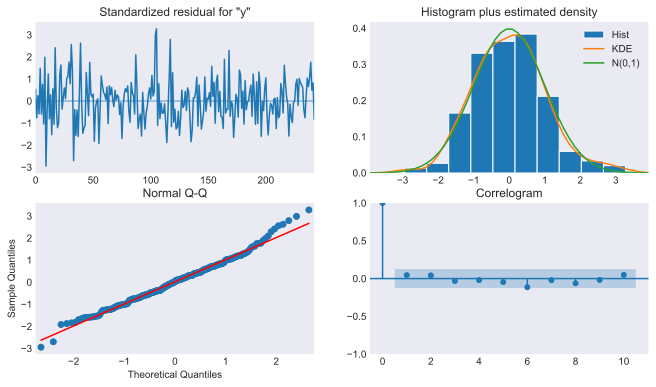

In [463]:
# fit the model to the train set and look at residual diagnostics 

sarimat_model = SARIMAX(ttrain['y'], order = (3,1,0), seasonal_order=(1,1,1,12), trend = 't', simple_differencing=False)

sarimat_fit = sarimat_model.fit(disp = False)

sarimat_fit.plot_diagnostics(figsize = (11,6));

The residuals looks pretty good: it very much resembles a white noise. It is almost Gaussian, QQ plot looks good, and no correlation between lagged residuals. Lets check this statement quantitatively with and ljung-box test

In [464]:
residst = sarimat_fit.resid

df_ljungbox = acorr_ljungbox(residst, lags=np.arange(1,10,1))

df_ljungbox

,lb_stat,lb_pvalue
1,1.100667,0.294120
2,3.887526,0.143164
3,3.923133,0.269885
4,4.008462,0.404862
5,4.873864,0.431467
6,7.412316,0.284392
7,8.329881,0.304406
8,9.505484,0.301462
9,11.718779,0.229631


No correlation between lagged residuals, all have p-values larger than 0.05 therefore we can not reject the null hypothesis: Residuals are white noise!

In [465]:
# get predictions using the start and end index of the test set

sarima_test_tpreds = sarimat_fit.get_prediction(256,279).predicted_mean

# lets also get the confidence interval
conf_int_testdf = sarimat_fit.get_prediction(256,279).conf_int(alpha = 0.05)

# inverse box-cox 
sarima_test_preds = inverse_boxcox(sarima_test_tpreds, lamb)
sarima_conf_int = inverse_boxcox(conf_int_testdf, lamb)

# add them to the test df where we collect all results and actual values

test['yhat_sarimat'] = sarima_test_preds.values

test[['yhat_sarimat_l','yhat_sarimat_u']] = sarima_conf_int.values

In [466]:
# MAE of best SARIMA model with trend 

mae_sarimat = mean_absolute_error(test['y'], test['yhat_sarimat'])

print(f"Test MAE of SARIMA with trend: {mae_sarimat:.3f}")

Test MAE of SARIMA with trend: 0.252


Almost a factor of 2 improvement in the MAE. This is quite good and we may accept such improvement by paying the price of working with a more complex model. 

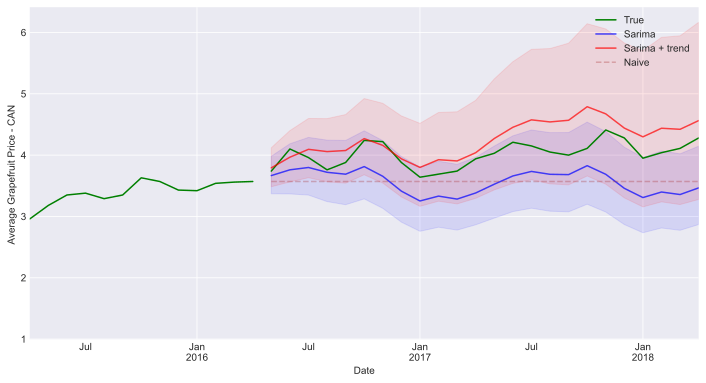

In [467]:
# Visualize the forecasts

train.index = train['ds']
test.index= test['ds']

fig, axes = plt.subplots(figsize = (12,6))

train['y'].plot(ax = axes, color = 'green', label = '')
test['y'].plot(ax = axes, color = 'green', label = 'True')
test['yhat_sarima'].plot(ax = axes, color = 'blue', alpha = 0.7, label = 'Sarima')
test['yhat_sarimat'].plot(ax = axes, color = 'red', alpha = 0.7, label = 'Sarima + trend')

test['naive'].plot(ax = axes, color = 'brown', ls = '--', alpha = 0.3, label = 'Naive')


axes.fill_between(x = test.index, y1 = test['yhat_sarima_l'], y2 = test['yhat_sarima_u'], color = 'blue', alpha = 0.1)
axes.fill_between(x = test.index, y1 = test['yhat_sarimat_l'], y2 = test['yhat_sarimat_u'], color = 'red', alpha = 0.1)




axes.set_xlim(train.index[-13],'2018-04-30')
axes.set_xlabel('Date')
axes.set_ylabel("Average Grapefruit Price - CAN ")
axes.legend()

axes.grid()

The predictions follow the actual values much more closely! The winner is $\textrm{SARIMA}(3,1,0)(1,1,1)_{12}$ with a drift by setting `trend = 't'`. 

In [470]:
sarimat_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  256
Model:             SARIMAX(3, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 320.714
Date:                              Sat, 08 Jun 2024   AIC                           -627.428
Time:                                      00:15:45   BIC                           -602.976
Sample:                                           0   HQIC                          -617.579
                                              - 256                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        5.04e-06   1.52e-05      0.332      0.740   -2.47e-05    3.48e-05
ar.L1         -0.2104      0.059     -3.554      0.000      -0.326      -0.094
ar.L2         -0.1674      0.060     -2.786      0.005      -0.285      -0.050
ar.L3         -0.1663      0.068     -2.463      0.014      -0.299      -0.034
ar.S.L12      -0.0524      0.108     -0.484      0.628      -0.265       0.160
ma.S.L12      -0.5606      0.104     -5.388      0.000      -0.765      -0.357
sigma2         0.0041      0.000     11.885      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 5.69
Prob(Q):                              0.48   Prob(JB):                         0.06
Heteroskedasticity (H):               0.62   Skew:                             0.28
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Extensions:

- Keeping our motto as "always experiment!" we can try including combinations of trend to our hyperparameter grid modfying `auto_SARIMAX()` or we can simply stick with the linear trend and work with second/third model in the `AIC` list. Notice that the p-value of the drift term (as well as the coefficient of auto-regressive seasonal part) is large so it is not statistically significant. Trying different `trend` options may render the coefficeints more robust.  

- We can try to implement the same procedure with the un-transformed data, this could help us to see if the box-cox transformation we did useful or not. 

